# SVM classification on the Loans
Author: Tomas Hobza

In [1]:
# SVM classification on the Loans dataset
# Author: Tomas Hobza

from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (balanced_accuracy_score, f1_score, 
                             precision_score, recall_score, accuracy_score,
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import time

# set random seed for reproducibility
np.random.seed(42)

## 0. Load the dataset

In [2]:
## 0. Load the dataset

# Load the parquet files
df = pd.read_parquet('loan_train_cleaned.parquet')

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['grade'].value_counts())
print(f"\nClass balance ratio: {df['grade'].value_counts().min() / df['grade'].value_counts().max():.3f}")

# Display first few rows
print("\nFirst 5 rows:")
display(df.head())

# Check for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

Dataset shape: (10000, 91)

Class distribution:
grade
C    2989
B    2881
A    1821
D    1449
E     621
F     182
G      57
Name: count, dtype: int64

Class balance ratio: 0.019

First 5 rows:


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,...,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,grade
ID,,,,,,,,,,,,,,,,,,,,,
24341,12500,12500,12500,36,7.21,387.17,< 1 year,MORTGAGE,81000.0,Not Verified,...,N,6,2018,6,2000,2,2019,2,2019,A
67534,33850,33850,33775,60,20.99,915.57,1 year,MORTGAGE,80000.0,Source Verified,...,N,10,2015,9,1984,2,2019,2,2019,E
35080,10000,10000,10000,60,20.0,264.94,< 1 year,RENT,36580.0,Not Verified,...,N,9,2017,10,2006,1,2018,11,2018,D
4828,20250,20250,20250,36,14.31,695.15,9 years,RENT,48700.0,Source Verified,...,N,0,2015,6,1996,6,2016,9,2017,C
59259,25000,25000,25000,36,14.99,866.52,1 year,MORTGAGE,85000.0,Source Verified,...,N,11,2016,0,2002,2,2019,2,2019,C



Missing values: 0


Not all features are numeric which is wouldn't work for SVM as it's a mathematical model. We need to do some further preprocessing before training and experimenting.

In [3]:
# print all non-numeric columns that are ordered categorical
ordered_cat_cols = []
print("\nOrdered categorical columns:")
for col in df.select_dtypes(include=['category']).columns:
    if df[col].cat.ordered:
        ordered_cat_cols.append(col)
        print(f"- {col} with order: {df[col].cat.categories}")

print(f"\nAll ordered categorical columns: {ordered_cat_cols}")

# print all non-numeric columns that are unordered categorical
unordered_cat_cols = []
print("\nUnordered categorical columns:")
for col in df.select_dtypes(include=['category']).columns:
    if not df[col].cat.ordered:
        unordered_cat_cols.append(col)
print(f"\nAll unordered categorical columns: {unordered_cat_cols}")



Ordered categorical columns:
- emp_length with order: Index(['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
       '6 years', '7 years', '8 years', '9 years', '10+ years'],
      dtype='object')
- grade with order: Index(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype='object')

All ordered categorical columns: ['emp_length', 'grade']

Unordered categorical columns:

All unordered categorical columns: ['home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


Now, we can encode the ordinal features as integers and the nominal we'll encode using one-hot encoding.

In [4]:
# Now, we can encode the ordinal features as integers and the nominal we'll encode using one-hot encoding.
# convert ordinal categorical columns to integer codes
for col in ordered_cat_cols:
    df[col] = df[col].cat.codes
# one-hot encode unordered categorical columns
df = pd.get_dummies(df, columns=unordered_cat_cols, drop_first=True)

In [5]:
# Split the data into features and labels
X = df.drop(columns=['grade'])
y = df['grade']

# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 8000 samples
Test set size: 2000 samples

Training set class distribution:
grade
2    2391
1    2305
0    1457
3    1159
4     497
5     145
6      46
Name: count, dtype: int64

Test set class distribution:
grade
2    598
1    576
0    364
3    290
4    124
5     37
6     11
Name: count, dtype: int64


## 1. Experiment - holdout vs cross-validation

In [6]:
# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

# ============= FEATURE SCALING =============
print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)

# Check feature scales before scaling
print("\nFeature statistics BEFORE scaling (training set):")
print(X_train.describe().loc[['mean', 'std', 'min', 'max']].round(3))

# Initialize and fit scaler on TRAINING data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaling from training

# Convert back to DataFrame to maintain feature names (optional, for readability)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nFeature statistics AFTER scaling (training set):")
print(X_train_scaled.describe().loc[['mean', 'std', 'min', 'max']].round(3))

print("\n✓ Features scaled using StandardScaler (zero mean, unit variance)")
print("✓ Scaler fitted on training set only, then applied to test set")
print("="*60)

## 1. Experiment - holdout vs cross-validation

print("\n" + "="*60)
print("HOLDOUT VS CROSS-VALIDATION COMPARISON")
print("="*60)
print("Primary metric: F1 Score (weighted)")
print("="*60)

# == HOLDOUT APPROACH ==
print("\n[1/2] Training with holdout validation...")
model = LinearSVC(class_weight='balanced', max_iter=2000, random_state=42)
start = time.time()
model.fit(X_train_scaled, y_train)
holdout_time = time.time() - start

y_pred = model.predict(X_test_scaled)
holdout_f1 = f1_score(y_test, y_pred, average='weighted')
holdout_bal_acc = balanced_accuracy_score(y_test, y_pred)

print(f"  Holdout F1 Score:         {holdout_f1:.4f}")
print(f"  Holdout Balanced Accuracy: {holdout_bal_acc:.4f}")
print(f"  Training time:             {holdout_time:.3f}s")

# == CROSS-VALIDATION APPROACH ==
print("\n[2/2] Training with 5-fold cross-validation...")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start = time.time()
# F1 Score (primary metric)
cv_scores_f1 = cross_val_score(
    LinearSVC(class_weight='balanced', max_iter=2000, random_state=42),
    X_train_scaled,
    y_train,
    cv=kf,
    scoring='f1_macro',
    n_jobs=-1
)

# Balanced Accuracy (secondary metric)
cv_scores_bal_acc = cross_val_score(
    LinearSVC(class_weight='balanced', max_iter=2000, random_state=42),
    X_train_scaled,
    y_train,
    cv=kf,
    scoring='balanced_accuracy',
    n_jobs=-1
)
cv_time = time.time() - start

print(f"  CV F1 Score per fold:         {[f'{s:.4f}' for s in cv_scores_f1]}")
print(f"  CV F1 Mean:                   {cv_scores_f1.mean():.4f}")
print(f"  CV F1 Std:                    ±{cv_scores_f1.std():.4f}")
print(f"\n  CV Balanced Accuracy per fold: {[f'{s:.4f}' for s in cv_scores_bal_acc]}")
print(f"  CV Balanced Accuracy Mean:    {cv_scores_bal_acc.mean():.4f}")
print(f"  CV Balanced Accuracy Std:     ±{cv_scores_bal_acc.std():.4f}")
print(f"\n  Training time:                {cv_time:.3f}s ({cv_time/holdout_time:.1f}x longer)")

# Comparison
print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)
print("F1 Score (Primary Metric):")
print(f"  Holdout:          {holdout_f1:.4f}")
print(f"  CV Mean:          {cv_scores_f1.mean():.4f}")
print(f"  Difference:       {abs(holdout_f1 - cv_scores_f1.mean()):.4f}")
print(f"  CV Std Dev:       ±{cv_scores_f1.std():.4f}")

print("\nBalanced Accuracy (Secondary Metric):")
print(f"  Holdout:          {holdout_bal_acc:.4f}")
print(f"  CV Mean:          {cv_scores_bal_acc.mean():.4f}")
print(f"  Difference:       {abs(holdout_bal_acc - cv_scores_bal_acc.mean()):.4f}")
print(f"  CV Std Dev:       ±{cv_scores_bal_acc.std():.4f}")

print("\nComputational Cost:")
print(f"  Holdout time:     {holdout_time:.3f}s")
print(f"  CV time:          {cv_time:.3f}s ({cv_time/holdout_time:.1f}x longer)")
print("="*60)

Training set size: 8000 samples
Test set size: 2000 samples

Training set class distribution:
grade
2    2391
1    2305
0    1457
3    1159
4     497
5     145
6      46
Name: count, dtype: int64

Test set class distribution:
grade
2    598
1    576
0    364
3    290
4    124
5     37
6     11
Name: count, dtype: int64

FEATURE SCALING

Feature statistics BEFORE scaling (training set):
      loan_amnt  funded_amnt  funded_amnt_inv    term  int_rate  installment  \
mean  15679.716    15679.716        15674.588  43.329    13.221      463.167   
std    9311.743     9311.743           9309.9  11.054     4.859      270.816   
min      1000.0       1000.0           1000.0    36.0      5.31        30.12   
max     40000.0      40000.0          40000.0    60.0     30.99      1717.63   

      emp_length  annual_inc     dti  delinq_2yrs  ...  total_bc_limit  \
mean       5.988   82299.381  19.154        0.302  ...       24450.609   
std        3.680   62329.051   9.674        0.846  ...        

/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

  CV F1 Score per fold:         ['0.5234', '0.5559', '0.5067', '0.5123', '0.5185']
  CV F1 Mean:                   0.5233
  CV F1 Std:                    ±0.0172

  CV Balanced Accuracy per fold: ['0.5424', '0.5728', '0.5312', '0.5374', '0.5379']
  CV Balanced Accuracy Mean:    0.5443
  CV Balanced Accuracy Std:     ±0.0146

  Training time:                91.481s (4.2x longer)

COMPARISON SUMMARY
F1 Score (Primary Metric):
  Holdout:          0.6684
  CV Mean:          0.5233
  Difference:       0.1450
  CV Std Dev:       ±0.0172

Balanced Accuracy (Secondary Metric):
  Holdout:          0.5419
  CV Mean:          0.5443
  Difference:       0.0025
  CV Std Dev:       ±0.0146

Computational Cost:
  Holdout time:     21.690s
  CV time:          91.481s (4.2x longer)


After comparing holdout vs. cross-validation and finding CV provides more robust estimates, we proceeded with cross-validation for our parameter experiments as the dataset size is managable and it provides a better picutre of the model performances.

## 2. Experiment - C parameter

In [7]:
## 2. Experiment - C Parameter (using Cross-Validation on Training Set)

print("="*60)
print("HYPERPARAMETER TUNING: C PARAMETER")
print("="*60)
print("Using 5-fold cross-validation on TRAINING SET ONLY")
print("Using SCALED features\n")

# Test range of C values (regularization strength)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
results_C = []

# Setup cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Testing C parameter values with CV on training set...")
for C in C_values:
    print(f"\n  C = {C}")
    model = LinearSVC(C=C, class_weight='balanced', max_iter=200, random_state=42)
    
    # Cross-validation on TRAINING set only (SCALED)
    start = time.time()
    cv_scores_bal_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    cv_scores_f1 = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='f1_weighted',  # Changed to f1_weighted for binary classification
        n_jobs=-1
    )
    cv_scores_precision = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='precision_weighted',
        n_jobs=-1
    )
    cv_scores_recall = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='recall_weighted',
        n_jobs=-1
    )
    cv_scores_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='accuracy',
        n_jobs=-1
    )
    cv_time = time.time() - start
    
    results_C.append({
        'C': C,
        'cv_accuracy_mean': cv_scores_acc.mean(),
        'cv_accuracy_std': cv_scores_acc.std(),
        'cv_balanced_accuracy_mean': cv_scores_bal_acc.mean(),
        'cv_balanced_accuracy_std': cv_scores_bal_acc.std(),
        'cv_f1_mean': cv_scores_f1.mean(),
        'cv_f1_std': cv_scores_f1.std(),
        'cv_precision_mean': cv_scores_precision.mean(),
        'cv_precision_std': cv_scores_precision.std(),
        'cv_recall_mean': cv_scores_recall.mean(),
        'cv_recall_std': cv_scores_recall.std(),
        'cv_time': cv_time
    })
    
    print(f"    CV F1 Score (weighted):   {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")
    print(f"    CV Balanced Accuracy:     {cv_scores_bal_acc.mean():.4f} ± {cv_scores_bal_acc.std():.4f}")
    print(f"    CV time: {cv_time:.3f}s")

# Convert to DataFrame for easier analysis
results_C_df = pd.DataFrame(results_C)
print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS SUMMARY (on Training Set)")
print("="*60)
display(results_C_df)

# Find best C based on CV F1 score (primary metric)
best_C_idx_f1 = results_C_df['cv_f1_mean'].idxmax()
best_C = results_C_df.loc[best_C_idx_f1, 'C']
best_f1 = results_C_df.loc[best_C_idx_f1, 'cv_f1_mean']
best_f1_std = results_C_df.loc[best_C_idx_f1, 'cv_f1_std']
best_bal_acc = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_mean']
best_bal_acc_std = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_std']

print(f"\nBest C value (based on F1 Score): {best_C}")
print(f"CV F1 Score:          {best_f1:.4f} ± {best_f1_std:.4f}")
print(f"CV Balanced Accuracy: {best_bal_acc:.4f} ± {best_bal_acc_std:.4f}")

HYPERPARAMETER TUNING: C PARAMETER
Using 5-fold cross-validation on TRAINING SET ONLY
Using SCALED features

Testing C parameter values with CV on training set...

  C = 0.001
    CV F1 Score (weighted):   0.5201 ± 0.0117
    CV Balanced Accuracy:     0.4322 ± 0.0105
    CV time: 8.347s

  C = 0.01
    CV F1 Score (weighted):   0.6145 ± 0.0112
    CV Balanced Accuracy:     0.5007 ± 0.0066
    CV time: 14.874s

  C = 0.1


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

    CV F1 Score (weighted):   0.6554 ± 0.0096
    CV Balanced Accuracy:     0.5321 ± 0.0051
    CV time: 52.360s

  C = 1


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

    CV F1 Score (weighted):   0.6648 ± 0.0083
    CV Balanced Accuracy:     0.5468 ± 0.0132
    CV time: 160.640s

  C = 10


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

    CV F1 Score (weighted):   0.6672 ± 0.0083
    CV Balanced Accuracy:     0.5532 ± 0.0188
    CV time: 232.835s

  C = 100


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

    CV F1 Score (weighted):   0.6673 ± 0.0068
    CV Balanced Accuracy:     0.5561 ± 0.0179
    CV time: 307.634s

CROSS-VALIDATION RESULTS SUMMARY (on Training Set)


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,C,cv_accuracy_mean,cv_accuracy_std,cv_balanced_accuracy_mean,cv_balanced_accuracy_std,cv_f1_mean,cv_f1_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_time
0,0.001,0.520250,0.009508,0.432160,0.010504,0.520127,0.011684,0.577335,0.012071,0.520250,0.009508,8.346525
1,0.010,0.617625,0.009490,0.500669,0.006562,0.614469,0.011202,0.634937,0.011001,0.617625,0.009490,14.874424
2,0.100,0.657875,0.008419,0.532063,0.005063,0.655381,0.009589,0.665582,0.010008,0.657875,0.008419,52.360334
3,1.000,0.665750,0.007357,0.546765,0.013204,0.664772,0.008338,0.673841,0.008479,0.665750,0.007357,160.639621
4,10.000,0.667875,0.007401,0.553180,0.018796,0.667156,0.008330,0.676469,0.008608,0.667875,0.007401,232.834993
5,100.000,0.667625,0.005895,0.556073,0.017871,0.667291,0.006813,0.676721,0.007204,0.667625,0.005895,307.633923



Best C value (based on F1 Score): 100.0
CV F1 Score:          0.6673 ± 0.0068
CV Balanced Accuracy: 0.5561 ± 0.0179


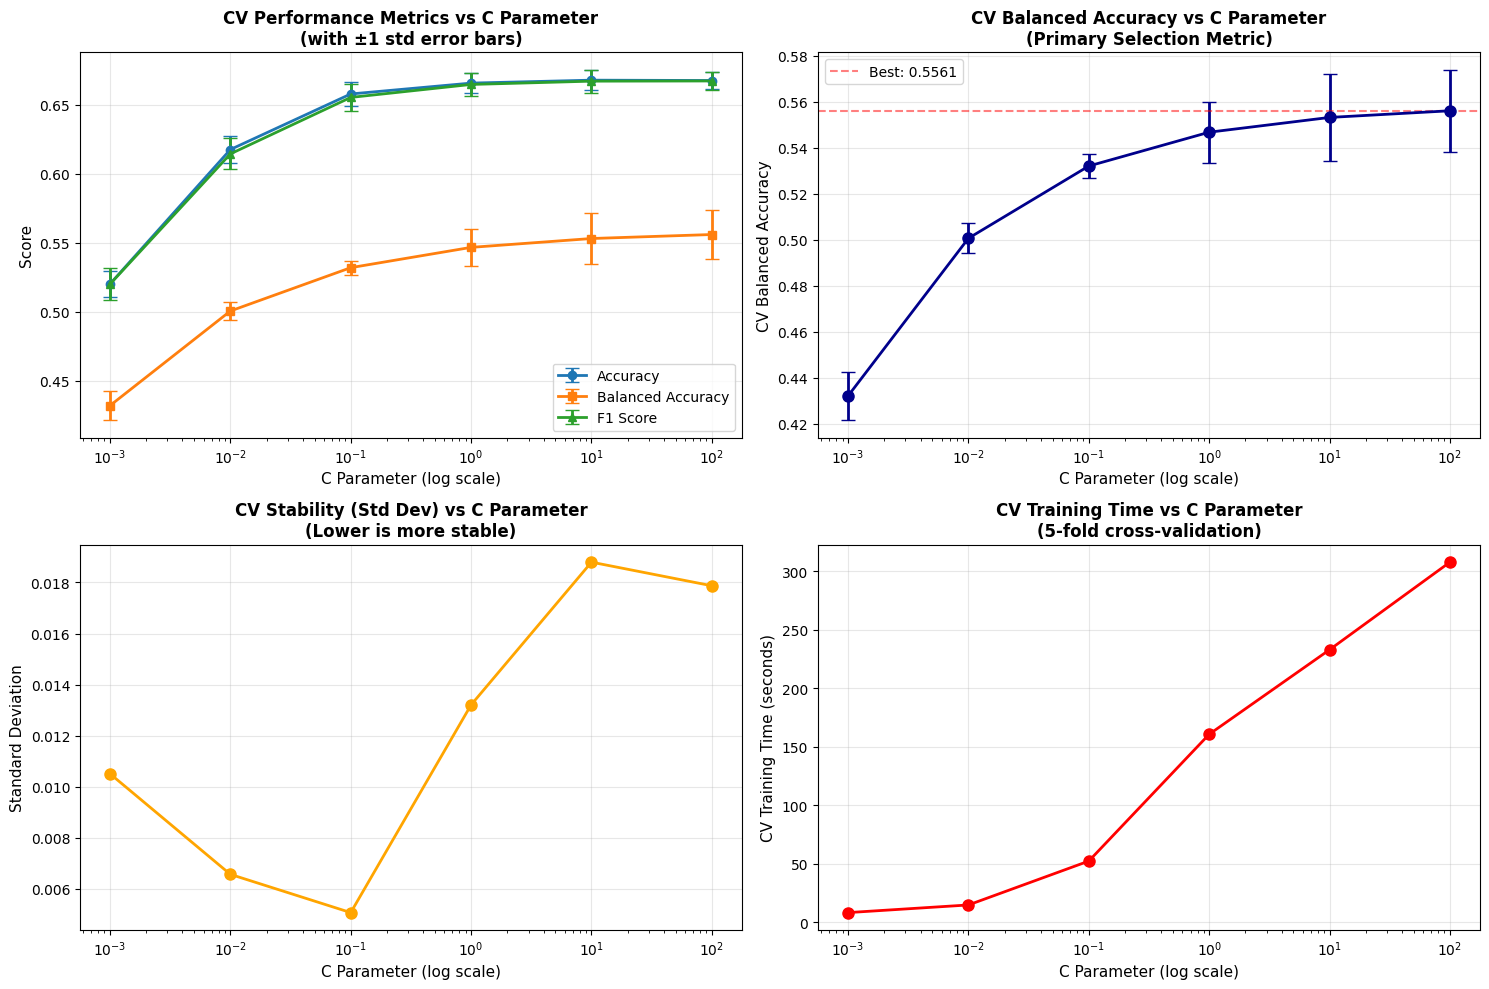

In [8]:
# Visualize C parameter impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Performance metrics vs C (with error bars)
ax1 = axes[0, 0]
ax1.errorbar(results_C_df['C'], results_C_df['cv_accuracy_mean'], 
             yerr=results_C_df['cv_accuracy_std'], 
             fmt='o-', label='Accuracy', linewidth=2, capsize=5)
ax1.errorbar(results_C_df['C'], results_C_df['cv_balanced_accuracy_mean'], 
             yerr=results_C_df['cv_balanced_accuracy_std'], 
             fmt='s-', label='Balanced Accuracy', linewidth=2, capsize=5)
ax1.errorbar(results_C_df['C'], results_C_df['cv_f1_mean'], 
             yerr=results_C_df['cv_f1_std'], 
             fmt='^-', label='F1 Score', linewidth=2, capsize=5)
ax1.set_xscale('log')
ax1.set_xlabel('C Parameter (log scale)', fontsize=11)
ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('CV Performance Metrics vs C Parameter\n(with ±1 std error bars)', 
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Balanced Accuracy with tighter focus
ax2 = axes[0, 1]
ax2.errorbar(results_C_df['C'], results_C_df['cv_balanced_accuracy_mean'], 
             yerr=results_C_df['cv_balanced_accuracy_std'], 
             fmt='o-', color='darkblue', linewidth=2, capsize=5, markersize=8)
ax2.axhline(y=best_bal_acc, color='red', linestyle='--', alpha=0.5, 
            label=f'Best: {best_bal_acc:.4f}')
ax2.set_xscale('log')
ax2.set_xlabel('C Parameter (log scale)', fontsize=11)
ax2.set_ylabel('CV Balanced Accuracy', fontsize=11)
ax2.set_title('CV Balanced Accuracy vs C Parameter\n(Primary Selection Metric)', 
              fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Standard deviation (uncertainty) vs C
ax3 = axes[1, 0]
ax3.plot(results_C_df['C'], results_C_df['cv_balanced_accuracy_std'], 
         'o-', color='orange', linewidth=2, markersize=8)
ax3.set_xscale('log')
ax3.set_xlabel('C Parameter (log scale)', fontsize=11)
ax3.set_ylabel('Standard Deviation', fontsize=11)
ax3.set_title('CV Stability (Std Dev) vs C Parameter\n(Lower is more stable)', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: CV training time vs C
ax4 = axes[1, 1]
ax4.plot(results_C_df['C'], results_C_df['cv_time'], 
         'o-', color='red', linewidth=2, markersize=8)
ax4.set_xscale('log')
ax4.set_xlabel('C Parameter (log scale)', fontsize=11)
ax4.set_ylabel('CV Training Time (seconds)', fontsize=11)
ax4.set_title('CV Training Time vs C Parameter\n(5-fold cross-validation)', 
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Experiment - max_iter parameter

In [9]:
## 3. Experiment - max_iter Parameter (Convergence Analysis with CV)

print("="*60)
print("HYPERPARAMETER TUNING: MAX_ITER")
print("="*60)
print(f"Using best C value: {best_C}")
print("Testing max_iter values with 5-fold CV on training set...")
print("Using SCALED features\n")

max_iter_values = [500, 1000, 2000, 5000]
results_iter = []

# Setup cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for max_iter in max_iter_values:
    print(f"\n  max_iter = {max_iter}")
    model = LinearSVC(C=best_C, class_weight='balanced', max_iter=max_iter, random_state=42)
    
    # Cross-validation on training set (SCALED)
    start = time.time()
    cv_scores_bal_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf,
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    cv_scores_f1 = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf,
        scoring='f1_weighted',
        n_jobs=-1
    )
    cv_time = time.time() - start
    
    # Train once on full training set to check convergence (SCALED)
    model_check = LinearSVC(C=best_C, class_weight='balanced', max_iter=max_iter, random_state=42)
    model_check.fit(X_train_scaled, y_train)  # ← Using scaled data
    converged = model_check.n_iter_ < max_iter
    actual_iters = model_check.n_iter_
    
    results_iter.append({
        'max_iter': max_iter,
        'cv_balanced_accuracy_mean': cv_scores_bal_acc.mean(),
        'cv_balanced_accuracy_std': cv_scores_bal_acc.std(),
        'cv_f1_mean': cv_scores_f1.mean(),
        'cv_f1_std': cv_scores_f1.std(),
        'actual_iterations': actual_iters,
        'converged': converged,
        'cv_time': cv_time
    })
    
    print(f"    Converged: {converged} (used {actual_iters} iterations)")
    print(f"    CV F1 Score:          {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")
    print(f"    CV Balanced Accuracy: {cv_scores_bal_acc.mean():.4f} ± {cv_scores_bal_acc.std():.4f}")
    print(f"    CV time: {cv_time:.3f}s")

results_iter_df = pd.DataFrame(results_iter)

print("\n" + "="*60)
print("CONVERGENCE ANALYSIS RESULTS")
print("="*60)
display(results_iter_df)

# Find best based on F1 score (primary metric)
best_iter_idx_f1 = results_iter_df['cv_f1_mean'].idxmax()
best_max_iter = results_iter_df.loc[best_iter_idx_f1, 'max_iter']

print(f"\nBest max_iter (based on F1 Score): {best_max_iter}")
print(f"CV F1 Score:          {results_iter_df.loc[best_iter_idx_f1, 'cv_f1_mean']:.4f}")
print(f"CV Balanced Accuracy: {results_iter_df.loc[best_iter_idx_f1, 'cv_balanced_accuracy_mean']:.4f}")
print(f"All models converged: {results_iter_df['converged'].all()}")

HYPERPARAMETER TUNING: MAX_ITER
Using best C value: 100.0
Testing max_iter values with 5-fold CV on training set...
Using SCALED features


  max_iter = 500


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

    Converged: False (used 500 iterations)
    CV F1 Score:          0.6668 ± 0.0073
    CV Balanced Accuracy: 0.5539 ± 0.0190
    CV time: 147.744s

  max_iter = 1000


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

    Converged: False (used 1000 iterations)
    CV F1 Score:          0.6669 ± 0.0071
    CV Balanced Accuracy: 0.5602 ± 0.0153
    CV time: 205.811s

  max_iter = 2000


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

    Converged: False (used 2000 iterations)
    CV F1 Score:          0.6665 ± 0.0073
    CV Balanced Accuracy: 0.5595 ± 0.0092
    CV time: 266.487s

  max_iter = 5000


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

    Converged: False (used 5000 iterations)
    CV F1 Score:          0.6666 ± 0.0074
    CV Balanced Accuracy: 0.5643 ± 0.0122
    CV time: 320.679s

CONVERGENCE ANALYSIS RESULTS


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,max_iter,cv_balanced_accuracy_mean,cv_balanced_accuracy_std,cv_f1_mean,cv_f1_std,actual_iterations,converged,cv_time
0,500,0.553919,0.018977,0.666821,0.007266,500,False,147.744359
1,1000,0.560176,0.015289,0.666868,0.007129,1000,False,205.811356
2,2000,0.559514,0.009169,0.666550,0.007290,2000,False,266.486578
3,5000,0.564272,0.012194,0.666575,0.007365,5000,False,320.679293



Best max_iter (based on F1 Score): 1000
CV F1 Score:          0.6669
CV Balanced Accuracy: 0.5602
All models converged: False


## Final Model Evaluation

In [11]:
## 4. Final Model Evaluation on Test Set

print("="*60)
print("FINAL MODEL EVALUATION ON TEST SET")
print("="*60)
print(f"Using best hyperparameters from CV:")
print(f"  C = {best_C}")
print(f"  max_iter = {best_max_iter}")
print(f"  Using SCALED features")
print()

# Train final model with best hyperparameters on SCALED training data
final_model = LinearSVC(C=best_C, class_weight='balanced', max_iter=best_max_iter, random_state=42)

print("Training final model on entire training set...")
start = time.time()
final_model.fit(X_train_scaled, y_train)  # ← Using scaled data
final_train_time = time.time() - start

print(f"Training completed in {final_train_time:.3f}s")
print(f"Converged: {final_model.n_iter_ < best_max_iter} (used {final_model.n_iter_} iterations)")

# Predictions on test set (SCALED)
print("\nEvaluating on test set...")
y_pred_final = final_model.predict(X_test_scaled)  # ← Using scaled data

# Comprehensive metrics
test_acc = accuracy_score(y_test, y_pred_final)
test_bal_acc = balanced_accuracy_score(y_test, y_pred_final)
test_f1 = f1_score(y_test, y_pred_final, average='weighted')
test_precision = precision_score(y_test, y_pred_final, average='weighted')
test_recall = recall_score(y_test, y_pred_final, average='weighted')

print("\n" + "="*60)
print("TEST SET PERFORMANCE (Unbiased Estimate)")
print("="*60)
print(f"  F1 Score (weighted):   {test_f1:.4f}  ← Primary Metric")
print(f"  Balanced Accuracy:     {test_bal_acc:.4f}")
print(f"  Accuracy:              {test_acc:.4f}")
print(f"  Precision (weighted):  {test_precision:.4f}")
print(f"  Recall (weighted):     {test_recall:.4f}")

# Compare CV training performance vs test performance
print("\n" + "="*60)
print("CV TRAINING vs TEST SET COMPARISON")
print("="*60)
cv_best_f1 = results_C_df.loc[best_C_idx_f1, 'cv_f1_mean']
cv_best_f1_std = results_C_df.loc[best_C_idx_f1, 'cv_f1_std']
cv_best_bal_acc = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_mean']
cv_best_bal_acc_std = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_std']

print(f"F1 Score:")
print(f"  CV (training):  {cv_best_f1:.4f} ± {cv_best_f1_std:.4f}")
print(f"  Test:           {test_f1:.4f}")
print(f"  Difference:     {abs(cv_best_f1 - test_f1):.4f}")

print(f"\nBalanced Accuracy:")
print(f"  CV (training):  {cv_best_bal_acc:.4f} ± {cv_best_bal_acc_std:.4f}")
print(f"  Test:           {test_bal_acc:.4f}")
print(f"  Difference:     {abs(cv_best_bal_acc - test_bal_acc):.4f}")

# Interpretation
if abs(cv_best_f1 - test_f1) < cv_best_f1_std:
    print("\n✓ Test F1 score is within CV std dev → Good generalization!")
else:
    print("\n⚠ Test F1 score differs from CV estimate → Check for overfitting/dataset shift")

print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
# Get class names if available, otherwise use default labels
class_names = ['Benign (False)', 'Malignant (True)'] if len(y.unique()) == 2 else None
print(classification_report(y_test, y_pred_final, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Benign', 'Malignant'] if len(y.unique()) == 2 else None,
            yticklabels=['Benign', 'Malignant'] if len(y.unique()) == 2 else None)
plt.title(f'Confusion Matrix - Final SVM (C={best_C}, max_iter={best_max_iter})\nTest Set Performance', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=11)
plt.xlabel('Predicted Label', fontsize=11)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {cm[0,0]:3d} - Correctly identified benign")
print(f"  False Positives (FP): {cm[0,1]:3d} - Benign misclassified as malignant")
print(f"  False Negatives (FN): {cm[1,0]:3d} - Malignant misclassified as benign ⚠")
print(f"  True Positives (TP):  {cm[1,1]:3d} - Correctly identified malignant")

# Calculate per-class metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # Same as recall for positive class

print(f"\nAdditional Clinical Metrics:")
print(f"  Specificity (True Negative Rate): {specificity:.4f} - correctly identify benign")
print(f"  Sensitivity (True Positive Rate): {sensitivity:.4f} - correctly identify malignant")
print(f"  False Negative Rate:              {fn/(fn+tp):.4f} ← Critical for cancer diagnosis")
print(f"  False Positive Rate:              {fp/(fp+tn):.4f}")

print("\n" + "="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"Final Model: LinearSVC")
print(f"Hyperparameters: C={best_C}, max_iter={best_max_iter}, class_weight='balanced'")
print(f"Preprocessing: StandardScaler (zero mean, unit variance)")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Balanced Accuracy: {test_bal_acc:.4f}")
print(f"Convergence: {final_model.n_iter_} iterations")
print("="*60)

FINAL MODEL EVALUATION ON TEST SET
Using best hyperparameters from CV:
  C = 100.0
  max_iter = 1000
  Using SCALED features

Training final model on entire training set...
Training completed in 31.504s
Converged: False (used 1000 iterations)

Evaluating on test set...

TEST SET PERFORMANCE (Unbiased Estimate)
  F1 Score (weighted):   0.6748  ← Primary Metric
  Balanced Accuracy:     0.5707
  Accuracy:              0.6760
  Precision (weighted):  0.6865
  Recall (weighted):     0.6760

CV TRAINING vs TEST SET COMPARISON
F1 Score:
  CV (training):  0.6673 ± 0.0068
  Test:           0.6748
  Difference:     0.0075

Balanced Accuracy:
  CV (training):  0.5561 ± 0.0179
  Test:           0.5707
  Difference:     0.0147

⚠ Test F1 score differs from CV estimate → Check for overfitting/dataset shift

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       364
           1       0.73      0.77      0.75       576
 

/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


TypeError: object of type 'NoneType' has no len()

<Figure size 800x600 with 0 Axes>